# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0])

In [2]:
# initial data analysis
print(data.info())
display(data.describe())
display(data.head())

# data sorted by date index ascending, resampled by 1 hour, sum
data.sort_index(inplace=True)
data = data.resample('1h').sum()

# post processing analysis
print(data.info())
display(data.describe())
display(data.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None


,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**- During data resampling, we've gone from 10-minute intervals per observation, to 60-minute/1-hour intervals, totaling the amount of taxis ordered per hour.**

**- Our total number of observations has gone from 26,496 to 4,416, this checks out seeing as though we've essentially divided by 6, and (26,496 / 4,416) = 6.**

**- Our window of data stretches between (March 1, 2018 @ 00:00:00) to (August 31, 2018 @ 23:00:00). 5 months, 30 days, 23 hours.**

**- As expected our summary statistics have also changed dramatically with this 'observation compression', all values (mean,median, max) have all increased, with the minimum remaining 0.**

## Analysis

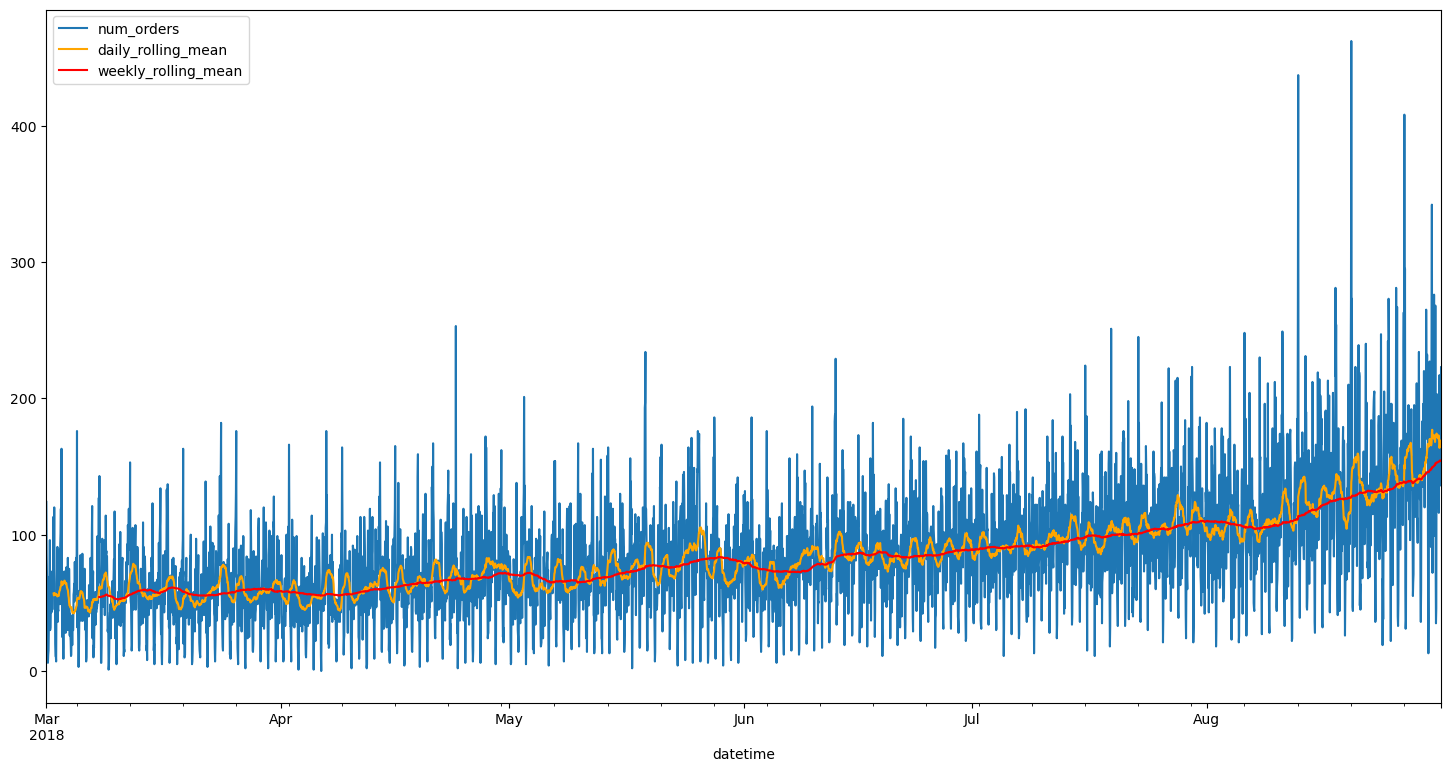

In [3]:
# capturing daily/weekly averages
data['daily_rolling_mean'] = data['num_orders'].rolling(24).mean()
data['weekly_rolling_mean'] = data['num_orders'].rolling(168).mean()

# plotting hourly totals, alongside daily & weekly averages
ax = data['num_orders'].plot(figsize=(18, 9))
data['daily_rolling_mean'].plot(ax=ax, color='orange')
data['weekly_rolling_mean'].plot(ax=ax, color='red')
ax.legend()

**- I've opted for both a 24-hour and 168-hour rolling mean, giving us the daily and weekly averages throughout our hourly observational window. There is slightly positive trend in our data, with mid-late August seeing the largest increase in average orders.**

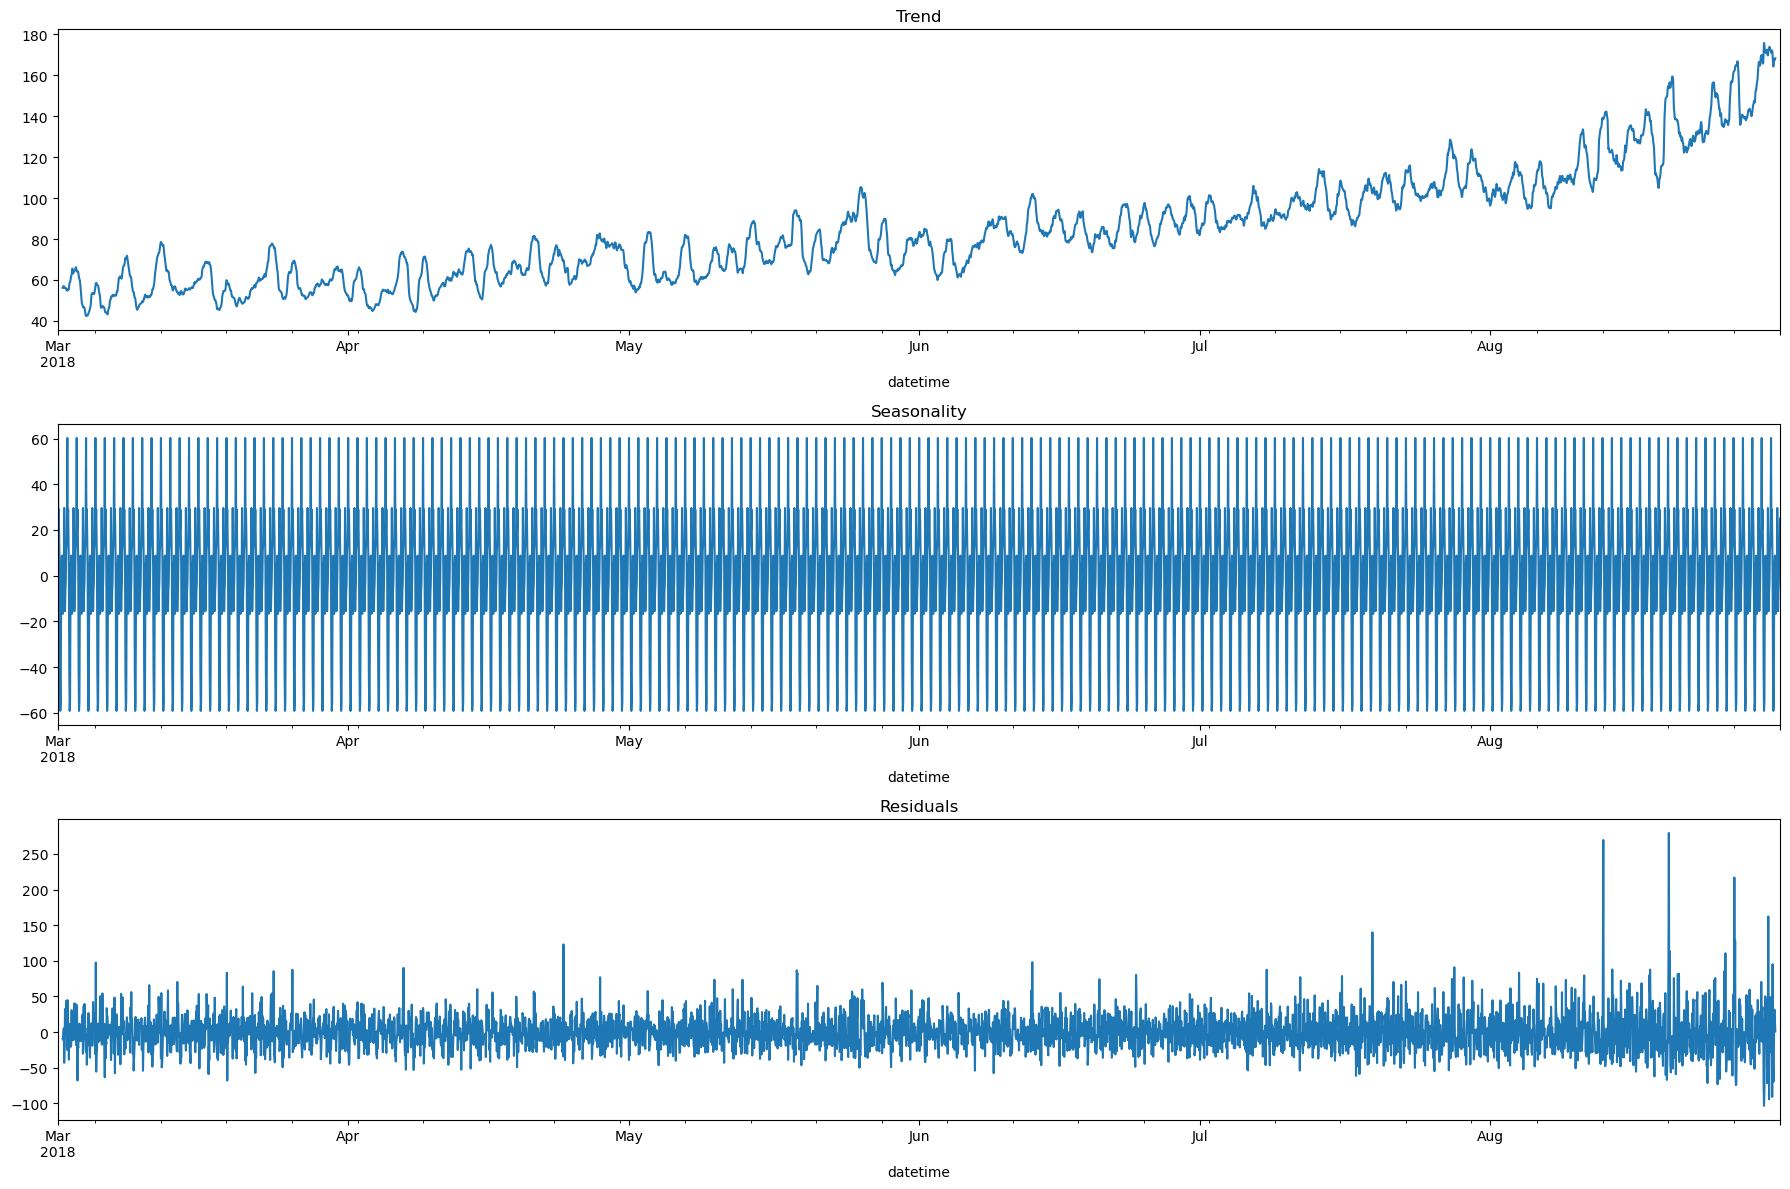

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

data = data.drop(['daily_rolling_mean', 'weekly_rolling_mean'], axis=1)
decomposed = seasonal_decompose(data)

plt.figure(figsize=(18, 12))

plt.subplot(311) # trend graph
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312) # seasonality graph
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313) # residuals graph
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

**- Our trend graph looks remarkably similar to our daily (24h) rolling average from the previous analysis step. We have a clear positive trend, meaning out data is non-stationary. The seasonality graph is way too crowded to see the cyclical pattern intervals, and our residuals graph represents seemingly random fluctuations not captured by seasonality or trend.**

**- I will be generating a seasonal decomposition graph sliced for the first week of august so we can more closely analyze the pattern.**

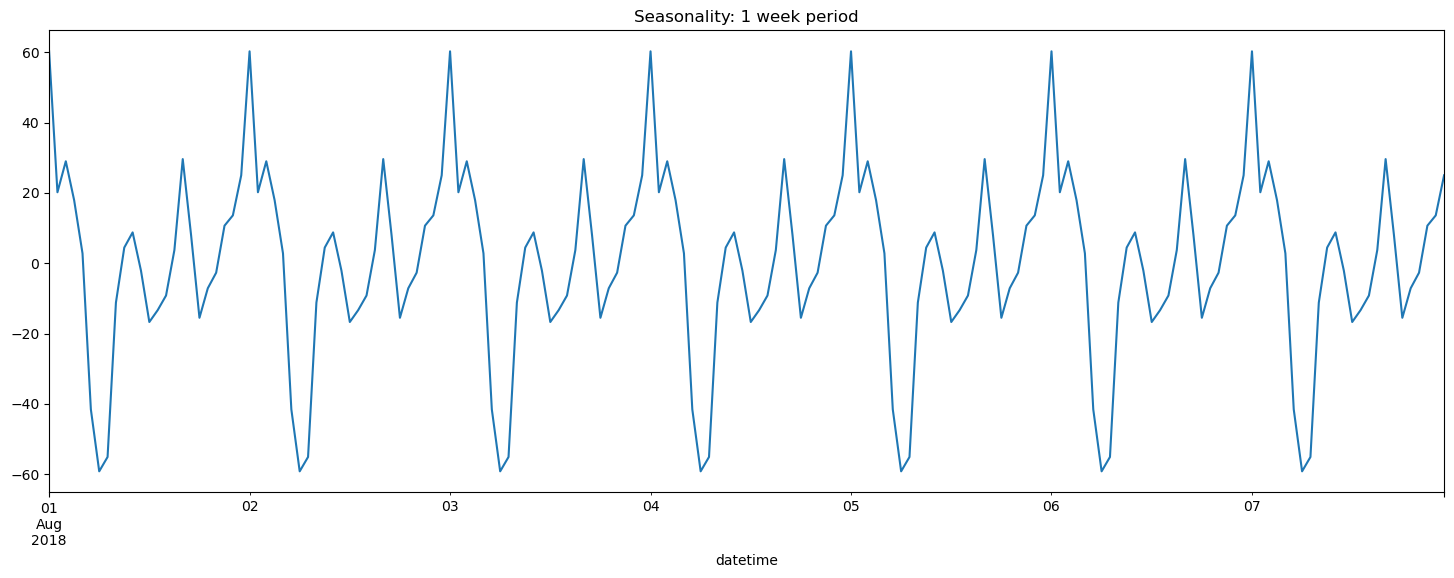

In [5]:
decomposed.seasonal['2018-08-01':'2018-08-07'].plot(figsize=(18, 6))
plt.title('Seasonality: 1 week period')
plt.show()

**- Our seasonal period is (m=24). It seems as though peak taxi times are between 6p-11p, with a rapid decline between 12a-4a, and this pattern is ocurring every 24 hours.**

## Training

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 9:1 train-test split, no shuffle
train, test = train_test_split(data, test_size=0.1, shuffle=False)

# RMSE function, tripleten site does not support native RMSE function
def RMSE(true, pred):
    return mean_squared_error(true, pred) ** 0.5

In [7]:
# sanity check: mean
print('Mean hourly taxi orders:', train['num_orders'].mean())

pred_mean = np.ones(test.shape) * train['num_orders'].mean()

print('RMSE (mean):', RMSE(test['num_orders'], pred_mean))

# sanity check: previous value
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]

print('RMSE (previous):', RMSE(test['num_orders'], pred_previous))

Mean hourly taxi orders: 78.29063915450428
RMSE (mean): 84.74414402014742
RMSE (previous): 58.856486242815066


**- Sanity check performed, our benchmark has been set. The mean gives us an RMSE that exceeds even the the average hourly orders, but this is expected since values change wildly in a 24-hour period. Shifting the values forward, and using the past value as the prediction gives us a much lower RMSE, which is also expected since we're using neighboring values that align with existing seasonality patterns.**

In [8]:
# feature engineering for LR: hour, day, day of week, month, lag, rolling mean
def make_features(data, max_lag, rolling_mean_size):
    data_copy = data.copy()
    data_copy['hour'] = data_copy.index.hour
    data_copy['day'] = data_copy.index.day  
    data_copy['day_of_week'] = data_copy.index.dayofweek
    data_copy['month'] = data_copy.index.month
    
    for lag in range(1, max_lag + 1):
        data_copy['lag_{}'.format(lag)] = data_copy['num_orders'].shift(lag)

    data_copy['rolling_mean'] = (data_copy['num_orders'].shift().rolling(rolling_mean_size).mean())

    return data_copy

In [ ]:
# ------ LINEAR REGRESSION ------ 
from sklearn.linear_model import LinearRegression

# feature engineering, train-test split, drop na
lr_data = make_features(data, 12, 24)
train, test = train_test_split(lr_data, test_size=0.1, shuffle=False)
train = train.dropna()

# train set features and target
train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']

# test set features and target
test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

# model initiation and fitting
model = LinearRegression()
model.fit(train_features, train_target)

# model prediction and scoring, train and test
pred_train = model.predict(train_features)
pred_test = model.predict(test_features)

print('Train RMSE (LR):', RMSE(train_target, pred_train))
print('Test RMSE (LR):', RMSE(test_target, pred_test))

Train RMSE (LR): 30.05258774899737
Test RMSE (LR): 51.08034353075656


**- LinearRegression scored better than our benchmarks against both the training and test sets, however, our LR model performance against the test set falls short of our goal: RMSE > 48**

**- We will be using our LR Test RMSE (51.08) as the new goal for our more advanced models to overcome.**

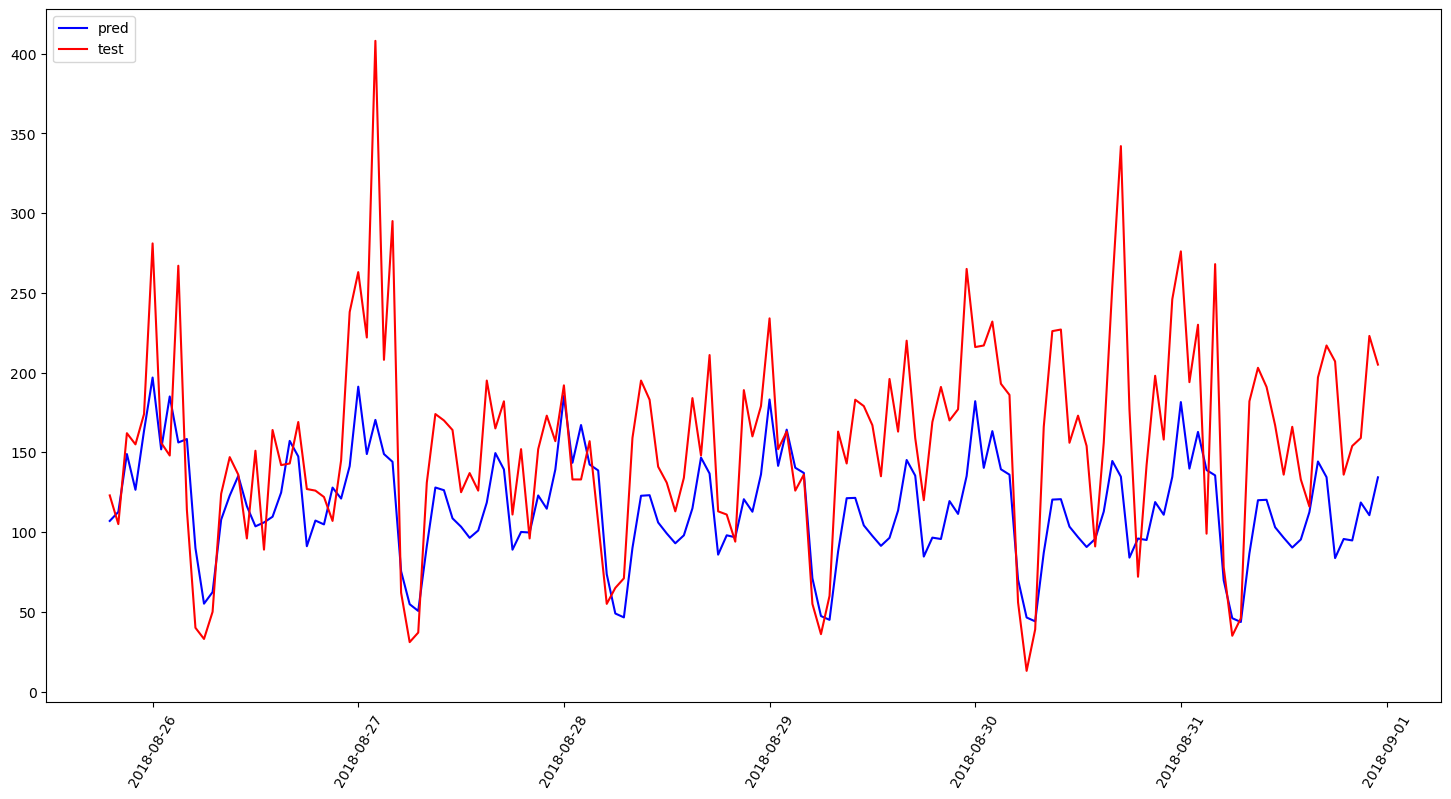

AutoRegression RMSE: 61.359699448518356


In [38]:
# ------ AUTO REGRESSION ------
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

recent_data = data['2018-07-01':]
train, test = train_test_split(recent_data, test_size=0.1, shuffle=False)

optimal = ar_select_order(endog=train, maxlag=30)
ar_order = optimal.ar_lags

ar_model = AutoReg(endog=train, lags=ar_order, seasonal=True)
ar_model = ar_model.fit()

start_value = len(train)
end_value = len(train) + len(test) - 1
ar_pred = ar_model.predict(start=start_value, end=end_value, dynamic=False)

plt.figure(figsize=(18, 9))
plt.plot(ar_pred, color='blue', label='pred')
plt.plot(test, color='red', label='test')
plt.legend(loc="upper left")
plt.xticks(rotation=60)
plt.show()

print('AutoRegression RMSE:', RMSE(test['num_orders'], ar_pred))

**- Using AutoRegression on Non-Stationary (non-linear trend) data has resulted in a higher RMSE than even LinearRegression. RMSE = 61.35 is the lowest we can achieve, even after applying the difference to transfrom non-stationary data to stationary.**

## Testing

# Review checklist

- [x]  Jupyter Notebook is open
- [ ]  The code is error-free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The data has been analyzed
- [ ]  The model has been trained and hyperparameters have been selected
- [ ]  The models have been evaluated. Conclusion has been provided
- [ ] *RMSE* for the test set is not more than 48